This short blog post relates to addressing a problem of *imbalanced* datasets. An imbalanced dataset is a dataset where the classes are not approximately equally represented. These are common in the areas of medical diagnosis, fraud detection, credit risk modeling, etc. For example, in building scorecards, it is not uncommon to see that the number of defaulted customers is dominated by the number of non-default cases (this actually means that loan originators do their job well and reject the majority of bad deals at the outset). Why should we care if our dataset contains imbalanced data? There are a number of common issues:

* The model may prioritize classifying the majority class accurately and accuracy, as a measure of model performance, may no longer be used. For example, suppose that the number of default cases represents 2% of the total number of observations. In this case, a simple model that always predicts the majority class, i.e. a non-default event, is going to achieve 98% accuracy. However, the value of such a model in decision making is questionable at best. 
* In real-world domains, imbalanced datasets usually arise as a consequence of building decision systems trying to distinguish between common occurrences and rare but **costly** alternatives. As an example, consider the problem of accurately diagnosing cancer. The rate of new incidents of cancer are around 0.44%, according to National Cancer Institute (https://www.cancer.gov/about-cancer/understanding/statistics). However, the costs associated with making a Type I error (classifying a healthy patient as having cancer) as compared to the costs of committing a Type II error, i.e. failing to diagnose cancer in people with the disease, might vary significantly. The latter is likely to be much higher as it may lead to a loss of precious time in starting a chemotherapy and may lead to death. 

Over the years, scientific community has devised a number of ways to address the problem. Roughly, these can be split into *algorithm-driven* and *data-driven* solutions. Algorithm-driven solutions work by altering the way algorithms, which are used to build predictive systems, work. For example, a data scientist may change the costs associated with committing Type I and Type II errors in an attempt to make an algorithm aware of the possible trade-offs. Alternatively, *bossting* (https://en.wikipedia.org/wiki/Boosting_(machine_learning)) algorithms may be used. 

On the other hand, data-driven methods work by artificially increasing (decreasing) observations belonging to the minority (majority) class. In particular, we are going to demonstrate the *Synthetic Minority Over-sampling TEchnique* (SMOTE) as was proposed by Chawla et al. (2002). The algorithm works by oversampling the minority class by generating synthetic observations along the line segments connecting the nearest minority class neighbors in the feature space.

To demonstrate how the technique can be implemented in Python, we would require the following libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

First things first, we need to get an imbalanced dataset. To do that, we are going to make use of *make_classification* functionality of scikit-learn library and generate a dataset consisting of 1,000 observations belonging to 2 classes. The majority class, class 0, will represent 98% of all observations. For the sake of simplicity, only 2 informative independent variables are used. This will also make visualizations possible. 

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, weights=[0.98], class_sep=0.7, random_state=4)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

Let us create a simple scatter plot and see how the two classes are distributed in the feature space. 

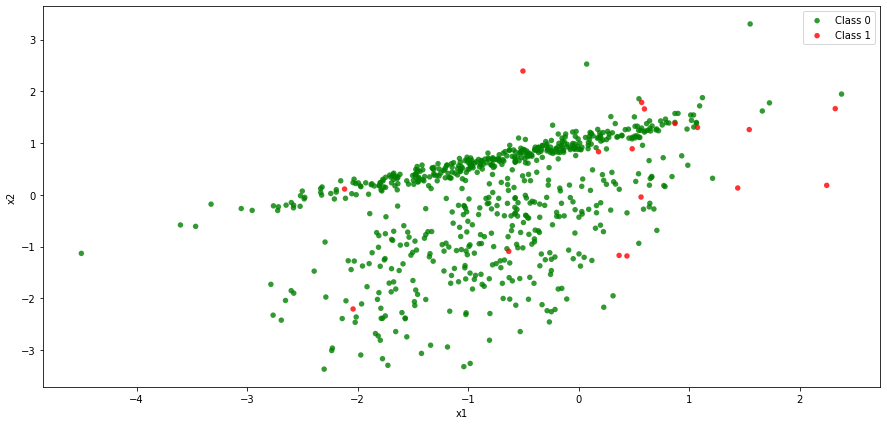

In [3]:
g1 = x_train[y_train==0]
g2 = x_train[y_train==1]
data = (g1, g2)
colors = ('green', 'red')
groups = ('Class 0', 'Class 1')
fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 1, 1)
for datum, color, group in zip(data, colors, groups):
        ax.scatter(datum.T[0], datum.T[1], alpha=0.8, c=color, edgecolors='none', s=30, label=group)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.legend(loc='best')

The scatter plot clearly shows that class 0 observations dominate over class 1 observations and it may be hard for us to devise a rule that would find an accurate bound separating the two classes.

Let us now fit the logistic regression model and assess its performance on the test set. 

In [4]:
model1 = LogisticRegression()
model1.fit(x_train, y_train)
model1.score(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9771428571428571

The obtained accuracy on the training set is almost 98% and it may seem that the algorithm does a good job at distinguishing between the two classes. Can we expect the same accuracy on the test set? 

In [5]:
model1.score(x_test, y_test)

0.9766666666666667

The accuracy on the test is the same as on the training set indicating that overfitting is an unlikely issue in our case. However, as we mentioned in the introduction, accuracy may not be the right performance metric to use. For that reason, we are going to utilize the F1 score (https://en.wikipedia.org/wiki/F1_score) metric. For those who do not remember, F1 score is the harmonic mean of precision and recall:

$$F1 \hspace{1mm} score = 2 \times \frac{precision \times recall}{precision + recall},$$

where 

$$precision = \frac{True \hspace{1mm} positive}{True \hspace{1mm} positive + False \hspace{1mm} positive}$$

and 

$$recall = \frac{True \hspace{1mm} positive}{True \hspace{1mm} positive + False \hspace{1mm} negative}.$$

Let us now see what value of F1 score the fitted logistic regression achieves on the test set. 

In [6]:
f1_score(model1.predict(x_test), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.0

The obtained value of 0 means that both precision and recall are equal to 0 or, in other words, the are no true positives, and the algorithm failed to correctly identify a case belonging to class 1. The next step is to investigate the associated confusion matrix.

In [7]:
conf = confusion_matrix(model1.predict(x_test), y_test)
conf

array([[293,   7],
       [  0,   0]])

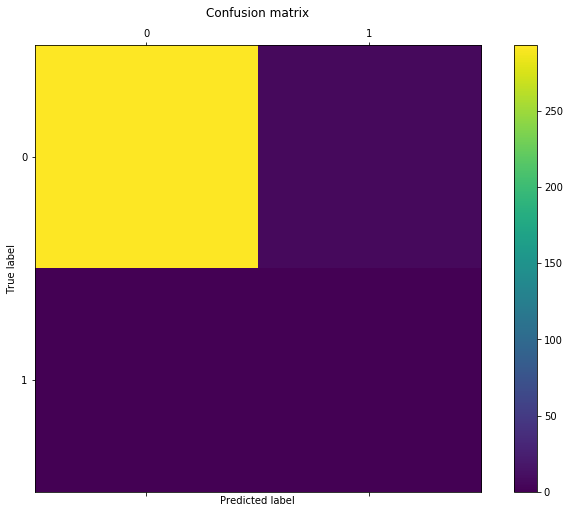

In [8]:
fig1 = plt.figure(figsize=[12, 8])
plt.matshow(conf, fignum=1)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we may infer from the above heat map, the logistic regression predicted that all 300 cases in the test set belong to class 0. This rule resulted in the algorithm being correct 293 times out of 300 and thence the correspondingly high accuracy of almost 98%. However, if we think about the problem in terms of cancer diagnosis, using this algorithm would mean that 7 patients would go away with the disease undetected, which is a horrible performance that would lead to very costly consequences both for the hospital and the patients. 

The poor performance of the algorithm is the direct consequence of the imbalanced nature of the dataset. Instead, we are now going to use the SMOTE algorithm to synthetically increase the proportion of the minority class cases and make it equal to 50%. 

In [9]:
smote = SMOTE(sampling_strategy=1, k_neighbors=10, random_state=4)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

To generate synthetic observations from the minority class, we looked at the 10 nearest neighbors of a given minority class case in the initial dataset. The figure below demonstrates how the classes are distributed in the feature space following the treatment. 

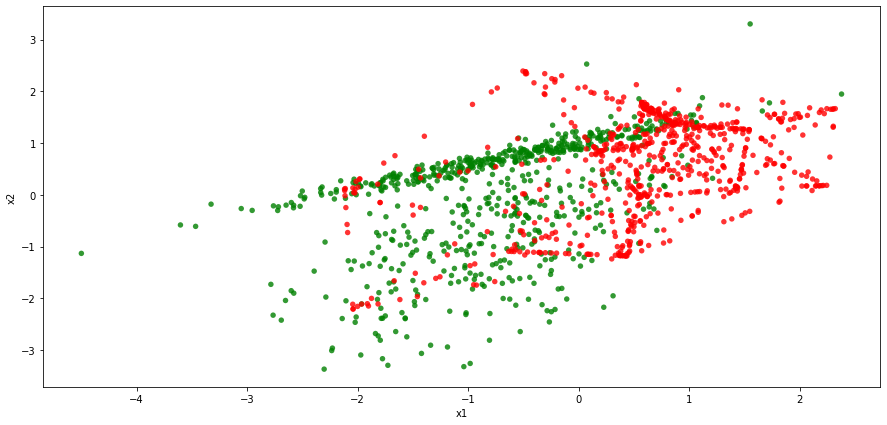

In [10]:
fig2 = plt.figure(figsize=[15, 7])
ax2 = fig2.add_subplot(1, 1, 1)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
g1 = x_resampled[y_resampled==0]
g2 = x_resampled[y_resampled==1]
data = (g1, g2)
for datum, color, group in zip(data, colors, groups):
    ax2.scatter(datum.T[0], datum.T[1], alpha=0.8, c=color, edgecolors='none', s=30, label=group)
plt.show()

While there is still a certain degree of overlap between the two classes in the augmented dataset, it looks that the separating rule may be easier to devise now. As such, observations belonging to class 1 tend to be associated with higher values if x1 and higher values of x2. 

To check if the updated dataset is better suited for training a predictive model, we are going to refit a logistic regression model and asses it performance.

In [11]:
model1.fit(x_resampled, y_resampled)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
model1.score(x_resampled, y_resampled)

0.8023426061493412

The resulting accuracy on the training set is now 80% down from almost 98% in the original version of the dataset.

In [13]:
model1.score(x_test, y_test)

0.74

The obtained accuracy on the test set is 74%. Note that we did not alter the test set to facilitate comparison.

In [14]:
f1_score(model1.predict(x_test), y_test)

0.13333333333333333

The value of F1 metric is now 0.13 meaning that the model now manages to correctly identify classes belonging to class 1. To see what exactly the fitted model predicts, we are going to have a look at the associated confusion matrix. 

In [15]:
conf = confusion_matrix(model1.predict(x_test), y_test)
conf

array([[216,   1],
       [ 77,   6]])

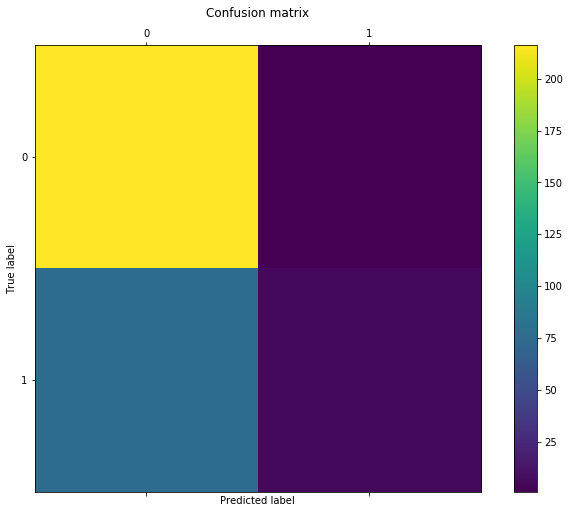

In [16]:
fig1 = plt.figure(figsize=[12, 8])
plt.matshow(conf, fignum=1)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

We now observe that the fitted model spends more effort in trying to identify observations belonging to class 1. As such, it predicted that 83 (77 + 6) out of 300 observations belong to class 1. Furthermore, only a single class 1 observation has been incorrectly labeled as belonging to class 0. However, one should also note that this increase in the true positive rate comes at a cost of higher false positive rate, i.e. higher number of observations belonging to class 0 classified as belonging to class 1.

Summing up, we can see that the SMOTE oversampling algorithm allows us to shift the weight from the majority class and make the algorithm more aware of the minority class. Such treatment resulted in a higher F1 score metric at a cost of a reduction in accuracy. 